Training and evaluating RF model for ABBV...
Training and evaluating RF model for GOOGL...
Training and evaluating RF model for GOOG...
Training and evaluating RF model for AMZN...
Training and evaluating RF model for AAPL...
Training and evaluating RF model for BAC...
Training and evaluating RF model for BRK-B...
Training and evaluating RF model for AVGO...
Training and evaluating RF model for COST...
Training and evaluating RF model for XOM...
Training and evaluating RF model for HD...
Training and evaluating RF model for JNJ...
Training and evaluating RF model for JPM...
Training and evaluating RF model for LLY...
Training and evaluating RF model for MA...
Training and evaluating RF model for META...
Training and evaluating RF model for MSFT...
Training and evaluating RF model for NFLX...
Training and evaluating RF model for NVDA...
Training and evaluating RF model for ORCL...
Training and evaluating RF model for PG...
Training and evaluating RF model for TSLA...
Training and evalua

,Stock,Model,MSE,RMSE,MAE,R2
0,ABBV,RF,521.123365,22.828127,15.237230,-0.140662
1,GOOGL,RF,1804.189247,42.475749,34.012026,-1.426418
2,GOOG,RF,1867.751767,43.217494,34.730045,-1.458978
3,AMZN,RF,3500.646006,59.166257,48.185715,-1.637281
4,AAPL,RF,10625.570791,103.080409,79.234156,-1.413996
5,BAC,RF,3.968030,1.991992,0.940966,0.954668
6,BRK-B,RF,14407.656520,120.031898,91.087383,-1.076619
7,AVGO,RF,4856.597260,69.689291,46.552978,-0.637091
8,COST,RF,117578.251872,342.896853,259.108405,-1.304478
9,XOM,RF,651.724760,25.528900,15.600954,-0.350356


Saved RF feature importances.


,Feature,Mean Importance
0,close_t-0,0.457587
1,high_t-0,0.126536
2,low_t-0,0.118818
3,open_t-0,0.022897
4,low_t-1,0.019693
5,open_t-1,0.017057
6,close_t-1,0.015365
7,high_t-1,0.006501
8,open_t-2,0.006426
9,low_t-2,0.005281


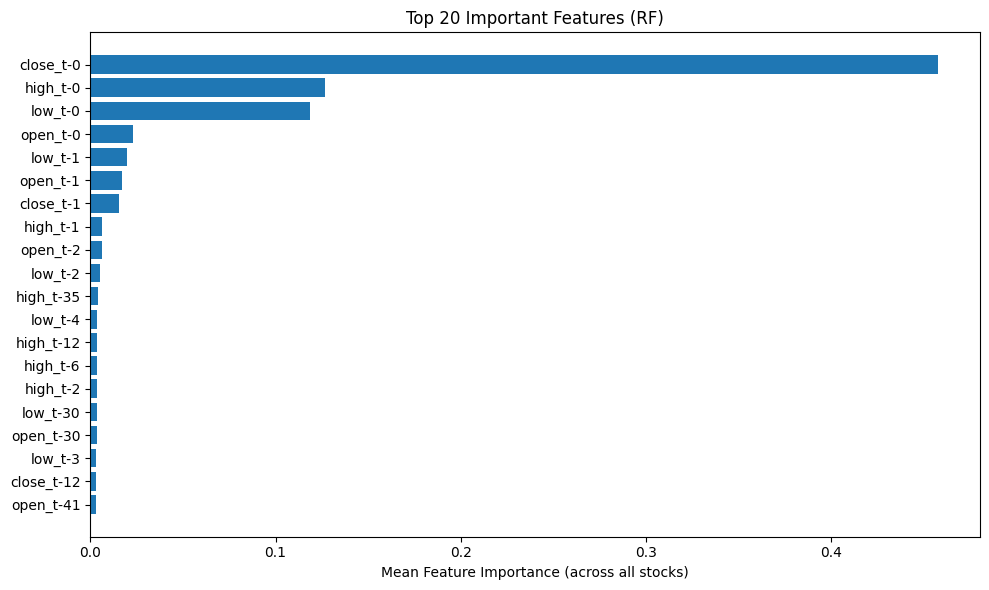

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import joblib
import matplotlib.pyplot as plt

# Configuration
CONFIG = {
    'input_csv': '../../data/daily_stock_price/filtered_top25sp_stocks.csv',
    'models_folder': 'rf_stock_models',
    'output_csv': 'rf_evaluation_results.csv',
    'feature_importance_csv': 'rf_feature_importance.csv',
    'features': ['open', 'high', 'low', 'close', 'volume'],
    'target': 'close',
    'sequence_length': 60,
    'train_split': 0.8,
    'random_seed': 42,
}

np.random.seed(CONFIG['random_seed'])
os.makedirs(CONFIG['models_folder'], exist_ok=True)
output_csv_path = os.path.join(CONFIG['models_folder'], CONFIG['output_csv'])
importance_csv_path = os.path.join(CONFIG['models_folder'], CONFIG['feature_importance_csv'])

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length, CONFIG['features'].index(CONFIG['target'])])
    return np.array(X), np.array(y)

def train_and_evaluate_rf_models():
    df = pd.read_csv(CONFIG['input_csv'])
    stocks = df['symbol'].unique()
    results = []
    feature_matrix = []
    feature_names = [f"{feat}_t-{i}" for i in range(CONFIG['sequence_length']-1, -1, -1) for feat in CONFIG['features']]

    for stock in stocks:
        print(f"Training and evaluating RF model for {stock}...")
        stock_data = df[df['symbol'] == stock][CONFIG['features']].values
        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(stock_data)
        X, y = create_sequences(scaled_data, CONFIG['sequence_length'])

        train_size = int(len(X) * CONFIG['train_split'])
        X_train, y_train = X[:train_size], y[:train_size]
        X_test, y_test = X[train_size:], y[train_size:]
        X_train_flat = X_train.reshape(X_train.shape[0], -1)
        X_test_flat = X_test.reshape(X_test.shape[0], -1)

        rf_model = RandomForestRegressor(n_estimators=100, random_state=CONFIG['random_seed'])
        rf_model.fit(X_train_flat, y_train)
        y_pred = rf_model.predict(X_test_flat)

        y_test_full = np.zeros((len(y_test), len(CONFIG['features'])))
        y_pred_full = np.zeros_like(y_test_full)
        target_idx = CONFIG['features'].index(CONFIG['target'])
        y_test_full[:, target_idx] = y_test
        y_pred_full[:, target_idx] = y_pred
        y_test_inv = scaler.inverse_transform(y_test_full)[:, target_idx]
        y_pred_inv = scaler.inverse_transform(y_pred_full)[:, target_idx]

        results.append({
            'Stock': stock,
            'Model': 'RF',
            'MSE': mean_squared_error(y_test_inv, y_pred_inv),
            'RMSE': np.sqrt(mean_squared_error(y_test_inv, y_pred_inv)),
            'MAE': mean_absolute_error(y_test_inv, y_pred_inv),
            'R2': r2_score(y_test_inv, y_pred_inv)
        })

        joblib.dump(rf_model, os.path.join(CONFIG['models_folder'], f"{stock}_rf_model.pkl"))
        joblib.dump(scaler, os.path.join(CONFIG['models_folder'], f"{stock}_scaler.pkl"))

        # Collect feature importance
        importances = rf_model.feature_importances_
        feature_matrix.append(importances)

    # Save evaluation metrics
    results_df = pd.DataFrame(results)
    results_df.to_csv(output_csv_path, index=False)
    print("Saved RF evaluation results.")
    display(results_df)

    # Aggregate feature importance
    importance_df = pd.DataFrame(feature_matrix, columns=feature_names)
    mean_importance = importance_df.mean().sort_values(ascending=False)
    mean_importance_df = mean_importance.reset_index()
    mean_importance_df.columns = ['Feature', 'Mean Importance']
    mean_importance_df.to_csv(importance_csv_path, index=False)
    print("Saved RF feature importances.")
    display(mean_importance_df.head(20))

    # Plot top 20 features
    plt.figure(figsize=(10, 6))
    top_k = 20
    top_features = mean_importance_df.head(top_k)
    plt.barh(top_features['Feature'][::-1], top_features['Mean Importance'][::-1])
    plt.xlabel("Mean Feature Importance (across all stocks)")
    plt.title(f"Top {top_k} Important Features (RF)")
    plt.tight_layout()
    plt.show()

# Run all
train_and_evaluate_rf_models()
